In [64]:
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import defaultdict

    1. https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_logistic_regression/

In [65]:
@torch.no_grad()
def get_all_preds(model,dataloader): 
    all_preds = torch.tensor([])
    for batch in dataloader:
        images,labels = batch
        images = images.view(-1,32*32*3)
        preds = model(images)
        all_preds = torch.cat((all_preds,preds),dim=0)
        
    return all_preds

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Loading CIFAR-10 Data


In [66]:
trainset = dsets.CIFAR10('./data',train= True, download= True, transform= transforms.ToTensor())
testset = dsets.CIFAR10('./data', train = False, download= True, transform= transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


#### Checking Dataset


In [67]:
# Length of training and test data
print("Length of training data: ",len(trainset))
print("Length of test data: ",len(testset))


Length of training data:  50000
Length of test data:  10000


In [68]:
# Let's check the first image
print(trainset[0][0].size()) # torch.Size([3, 32, 32]) [channel,height,width]
#print(trainset[0][0])


torch.Size([3, 32, 32])


In [69]:
# Let's check label on the First image
print(trainset[0][1])
CLASSES=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse', 'ship','truck')

print(CLASSES[trainset[0][1]])

6
frog


##### Visualization

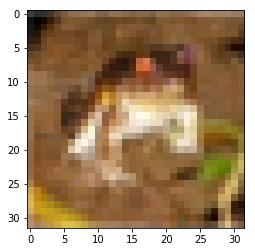

In [70]:
img = trainset[0][0]
conv_to_pil = transforms.ToPILImage()
plt.imshow(conv_to_pil(img))

## Creating Mini-batches


In [89]:
torch.manual_seed(28)
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)


train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                           batch_size= batch_size, shuffle=True)



20


## Building Model

In [90]:
class LogisticRegressionModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LogisticRegressionModel,self).__init__()
        self.linear1 = nn.Linear(input_dim,2048)
        self.linear2 = nn.Linear(2048, output_dim)
        self.relu = nn.ReLU() #activation function
        self.total_loss =[]
        
    def forward(self,x):
        out = self.relu(self.linear1(x))
        output = self.linear2(out)
        
        return output
    
    def train_model(self,data_loader,optimizer,criterion,epoch):
        iter = 0 
        accuracy=0
        grad_norm_dict=defaultdict(list)
        total_loss = []
        
        for epoch in range(num_epochs):
            running_loss = 0
            for i,(images,labels) in enumerate (data_loader):
                #print(images.size()) # torch.Size([100, 3, 32, 32])[batch_size,clr,h,w]
                #print(images.view(-1,32*32*3).size()) #torch.Size([100, 3072])
                images = images.view(-1,32*32*3)
                                
                #clear gradient w.r.t parameters
                optimizer.zero_grad()
                
                # Forward Propagation
                outputs = model(images)
                
                # Calculate Loss
                loss = criterion(outputs,labels)
                                
                # Backpropagation
                # Get the grads w.r.t params
                loss.backward()
                # update params
                optimizer.step()
                   
                iter += 1 
                if iter % 500 ==0:
                    correct = 0 
                    total = 0 
                    
                    for test_imgs,test_labels in test_loader: 
                        test_imgs = test_imgs.view(-1,32*32*3)
                        test_output = model(test_imgs)
                        _,predicted = torch.max(test_output.data,1)
                        
                        # Total Number of labels
                        total += test_labels.size(0)
                        # Total correct prediction
                        correct += (predicted == test_labels).sum()
                        
                    accuracy = 100 * (correct.item()/total)            
                
                    print('Epoch: {}. Iteration: {}. Loss:{}. Accuracy: {}'.format(epoch,iter,loss.item(),accuracy))
                running_loss += loss.item()* images.size(0)
            
            layer_grad_norm = [p.grad.data.norm(2) for p in model.parameters()]
            grad_norm_dict['w1_grad_norm'].append(layer_grad_norm[0])
            grad_norm_dict['b1_grad_norm'].append(layer_grad_norm[1])
            grad_norm_dict['w2_grad_norm'].append(layer_grad_norm[2])
            grad_norm_dict['b2_grad_norm'].append(layer_grad_norm[3])
            
            total_loss.append(running_loss/len(trainset))
        
        return total_loss,grad_norm_dict
        

mymodel.train_model(data_loader,optimizer,learn_rate,epoch)

model = LogisticRegressionModel(input_dim, output_dim,data_loader,optimizer,learn_rate,epoch)

#### Instantiate Model

In [91]:
input_dim = 32*32*3
output_dim = 10 
model = LogisticRegressionModel(input_dim, output_dim)

#### Instantiate Loss and Optimizer

In [92]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate,momentum=0.9)
#optimizers = [torch.optim.SGD(model.parameters(), lr = learning_rate,momentum=0.9),
#             torch.optim.Adam(model.parameters(),lr=0.0001)]


In [93]:

total_loss,grad_norm_dict= model.train_model(train_loader,optimizer,criterion,num_epochs)

Epoch: 0. Iteration: 500. Loss:1.9293487071990967. Accuracy: 33.96
Epoch: 1. Iteration: 1000. Loss:1.8708429336547852. Accuracy: 36.41
Epoch: 2. Iteration: 1500. Loss:1.7711933851242065. Accuracy: 38.12
Epoch: 3. Iteration: 2000. Loss:1.7882574796676636. Accuracy: 39.7
Epoch: 4. Iteration: 2500. Loss:1.6619439125061035. Accuracy: 40.57
Epoch: 5. Iteration: 3000. Loss:1.8182278871536255. Accuracy: 42.04
Epoch: 6. Iteration: 3500. Loss:1.5384293794631958. Accuracy: 43.08
Epoch: 7. Iteration: 4000. Loss:1.5136572122573853. Accuracy: 43.89
Epoch: 8. Iteration: 4500. Loss:1.6753648519515991. Accuracy: 44.62
Epoch: 9. Iteration: 5000. Loss:1.4147849082946777. Accuracy: 44.21
Epoch: 10. Iteration: 5500. Loss:1.6352239847183228. Accuracy: 45.65
Epoch: 11. Iteration: 6000. Loss:1.3451069593429565. Accuracy: 45.1
Epoch: 12. Iteration: 6500. Loss:1.409328818321228. Accuracy: 46.86
Epoch: 13. Iteration: 7000. Loss:1.527618408203125. Accuracy: 47.08
Epoch: 14. Iteration: 7500. Loss:1.42554354667663

### Gradient Norm of Learnable parameters(w1,b1,w2,b2)

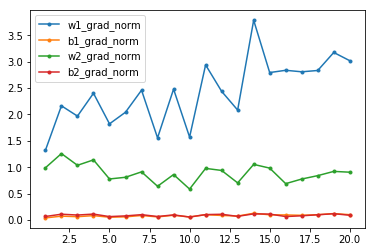

In [96]:
for k, v in grad_norm_dict.items():
    plt.plot(range(1, len(v) + 1), v, '.-', label=k)
   
plt.legend()  # To draw legend
plt.show()

In [97]:
'''
for optimizer in optimizers:
    total_loss=[]
    print(optimizer)
    total_loss,grad_norm_dict= model.train_model(train_loader,optimizer,criterion,num_epochs)
    print(total_loss)
    plt.plot(total_loss)
    del total_loss
    plt.show()
'''    

'\nfor optimizer in optimizers:\n    total_loss=[]\n    print(optimizer)\n    total_loss,grad_norm_dict= model.train_model(train_loader,optimizer,criterion,num_epochs)\n    print(total_loss)\n    plt.plot(total_loss)\n    del total_loss\n    plt.show()\n'

### Learning Curve (loss plot)

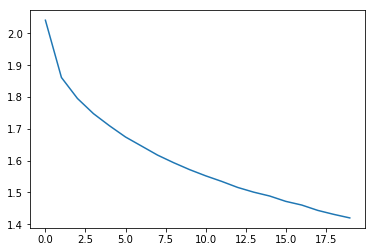

In [100]:
plt.plot(total_loss)

### Confusion Matrix

Confusion matrix, without normalization
[[2910  230  344  107   82   69  126  232  599  301]
 [ 223 3138   79   92   53   58  139  185  261  772]
 [ 422  128 2183  260  393  292  671  407  117  127]
 [ 169  127  575 1642  167  749  740  342  205  284]
 [ 353   77  944  194 1674  170  749  587  128  124]
 [ 133  114  633  851  203 1714  590  455  153  154]
 [  86   87  532  330  342  184 3059  193   70  117]
 [ 202   94  298  235  295  212  159 3152   86  267]
 [ 579  289  114   87   72   83   50   56 3310  360]
 [ 221  701  100  101   39   90  129  251  236 3132]]


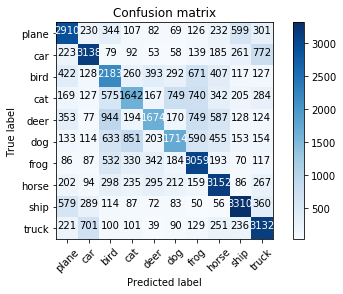

In [99]:
train_preds = get_all_preds(model, trainset)
train_preds_max=train_preds.argmax(dim=1) #tensor([6, 1, 9,  ..., 9, 8, 9])
cm = confusion_matrix(trainset.targets,train_preds_max)
plot_confusion_matrix(cm,CLASSES)